In [10]:
#Instalamos las librerías que vamos a usar
!pip install geopandas
!pip install sidetable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
#las cargamos
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable

#EDA

In [12]:
#Cargamos el dataset con el que vamos a trabajar y le damos un vistazo
df = pd.read_csv("https://cdn.buenosaires.gob.ar/"+
                 "datosabiertos/datasets/"+
                 "direccion-general-de-estadisticas-y-censos/"+
                 "encuesta-anual-hogares/encuesta-anual-hogares-2019.csv",
                 encoding="latin1")
Cols = list(pd.read_csv("https://cdn.buenosaires.gob.ar/"+
                 "datosabiertos/datasets/"+
                 "direccion-general-de-estadisticas-y-censos/"+
                 "encuesta-anual-hogares/encuesta-anual-hogares-2019.csv",
                 encoding="latin1", nrows=1))
df.head()

,id,nhogar,miembro,comuna,dominio,edad,sexo,parentesco_jefe,situacion_conyugal,num_miembro_padre,...,ingreso_per_capita_familiar,estado_educativo,sector_educativo,nivel_actual,nivel_max_educativo,años_escolaridad,lugar_nacimiento,afiliacion_salud,hijos_nacidos_vivos,cantidad_hijos_nac_vivos
0,1,1,1,5,Resto de la Ciudad,18,Mujer,Jefe,Soltero/a,Padre no vive en el hogar,...,9000,Asiste,Estatal/publico,Universitario,Otras escuelas especiales,12,PBA excepto GBA,Solo obra social,No,No corresponde
1,1,1,2,5,Resto de la Ciudad,18,Mujer,Otro no familiar,Soltero/a,Padre no vive en el hogar,...,9000,Asiste,Estatal/publico,Universitario,Otras escuelas especiales,12,Otra provincia,Solo plan de medicina prepaga por contratación...,No,No corresponde
2,2,1,1,2,Resto de la Ciudad,18,Varon,Jefe,Soltero/a,Padre no vive en el hogar,...,33333,Asiste,Privado religioso,Universitario,Otras escuelas especiales,12,CABA,Solo plan de medicina prepaga por contratación...,NaN,No corresponde
3,2,1,2,2,Resto de la Ciudad,50,Mujer,Padre/Madre/Suegro/a,Viudo/a,No corresponde,...,33333,No asiste pero asistió,No corresponde,No corresponde,Secundario/medio comun,17,CABA,Solo prepaga o mutual via OS,Si,2
4,2,1,3,2,Resto de la Ciudad,17,Varon,Otro familiar,Soltero/a,Padre no vive en el hogar,...,33333,Asiste,Privado religioso,Secundario/medio comun,EGB (1° a 9° año),10,CABA,Solo plan de medicina prepaga por contratación...,NaN,No corresponde


In [13]:
#Miramos sus variable, el tipo que son y si tienen nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14319 entries, 0 to 14318
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           14319 non-null  int64 
 1   nhogar                       14319 non-null  int64 
 2   miembro                      14319 non-null  int64 
 3   comuna                       14319 non-null  int64 
 4   dominio                      14319 non-null  object
 5   edad                         14319 non-null  int64 
 6   sexo                         14319 non-null  object
 7   parentesco_jefe              14319 non-null  object
 8   situacion_conyugal           14318 non-null  object
 9   num_miembro_padre            14319 non-null  object
 10  num_miembro_madre            14319 non-null  object
 11  estado_ocupacional           14319 non-null  object
 12  cat_ocupacional              14319 non-null  object
 13  calidad_ingresos_lab         14

Podemos ver que la columna 'comuna' aparece como numérica. Sin embargo, es una categórica, que más adelantre habrá que transformar para evitar errores en el modelo

In [14]:
#Tomamos el código visto en clase para tener un vistazo de las diversas medidas estadísticas de cada variale
from pandas.api.types import is_numeric_dtype
import numpy as np


def univariado_info(df):
  '''Calculo de informacion estadistias y genericas de cada columna de un dataframe'''

  #Creamos un dataframe con columnas especificas:

  df_info = pd.DataFrame(columns=['Cantidad', 'Tipo' , 'Missing', 'Unicos', 'Numeric'])
  #loop de todas las variables del dataframe
  for col in df:

      #obtengo info de la columna
      data_series = df[col]
      #lleno dataframe con las columnas iniciales
      df_info.loc[col] = [data_series.count(), data_series.dtype, data_series.isnull().sum(), data_series.nunique(), is_numeric_dtype(data_series)]

  #calculo el describe 
  df_describe = df.describe(include='all').T[['top', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
  #calculo sesgo y curtosis
  df_stats = pd.DataFrame([df.skew(), df.kurtosis()], index=['sesgo', 'kurt']).T

  return pd.concat([df_info,pd.concat([df_describe, df_stats], axis=1)], axis=1).fillna('-')


df_uni_stats = univariado_info(df)
df_uni_stats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Cantidad,Tipo,Missing,Unicos,Numeric,top,mean,std,min,25%,50%,75%,max,sesgo,kurt
id,14319,int64,0,5795,True,-,2710.024094,1535.910251,1.0,1473.0,2611.0,3898.0,5795.0,0.16901,-0.953158
nhogar,14319,int64,0,7,True,-,1.009638,0.126376,1.0,1.0,1.0,1.0,7.0,21.366705,687.880709
miembro,14319,int64,0,19,True,-,2.144982,1.354969,1.0,1.0,2.0,3.0,19.0,1.940715,8.605228
comuna,14319,int64,0,15,True,-,7.620644,4.236359,1.0,4.0,8.0,11.0,15.0,0.103211,-1.090936
dominio,14319,object,0,2,False,Resto de la Ciudad,-,-,-,-,-,-,-,-,-
edad,14319,int64,0,101,True,-,38.81549,23.11017,0.0,20.0,37.0,57.0,100.0,0.249452,-0.868539
sexo,14319,object,0,2,False,Mujer,-,-,-,-,-,-,-,-,-
parentesco_jefe,14319,object,0,9,False,Jefe,-,-,-,-,-,-,-,-,-
situacion_conyugal,14318,object,1,7,False,Soltero/a,-,-,-,-,-,-,-,-,-
num_miembro_padre,14319,object,0,9,False,No corresponde,-,-,-,-,-,-,-,-,-


### Conclusiones:

*   La moda de la categoria Dominio es el valor "Resto de la Ciudad"
*   Categoría dominio tiene 2 valores posibles
*   Por la categoría Sexo se puede ver que la moda es el valor "Mujer" siendo que solo existen los valores "Mujer" y "Varón"
*   La moda para la categoría Situacion_Conyugal es "Soltero"
*   La media para la categoría Edad es 38.8
*   La moda para Num_miembro_madre y Num_miembro_padre es "No corresponde"
*   Estado ocupacional tiene 3 valores posibles
*   Cat_ocupacional tiene 5 valores posibles. La moda es "No corresponde"
*   Calidad_ingresos_tot tiene 4 valores posibles y la moda es "Tuvo ingresos y declara montos"
*   Calidad_ingresos_familiares tiene 3 valores posibles y la moda es "Tuvo ingresos y declara montos"
*   La media de ingresos_tot es aprox. 26094
*   Estado_educativo tiene 3 valores posibles y la moda es "No asiste pero asistió"
*   Para el target la moda es "Secundario/medio comun"
*   Afiliacion_salud tiene 5 valores posibles y la moda es "Obra social"
*   Para cant_hijos_nac_vivos existen 14 valores posibles

Podemos observar que hay variables que les falta valores, ademas hay varias que son numericas , como tambien categoricas

Ahora vamos a generar análisis univariados de las variables que nos interesan.

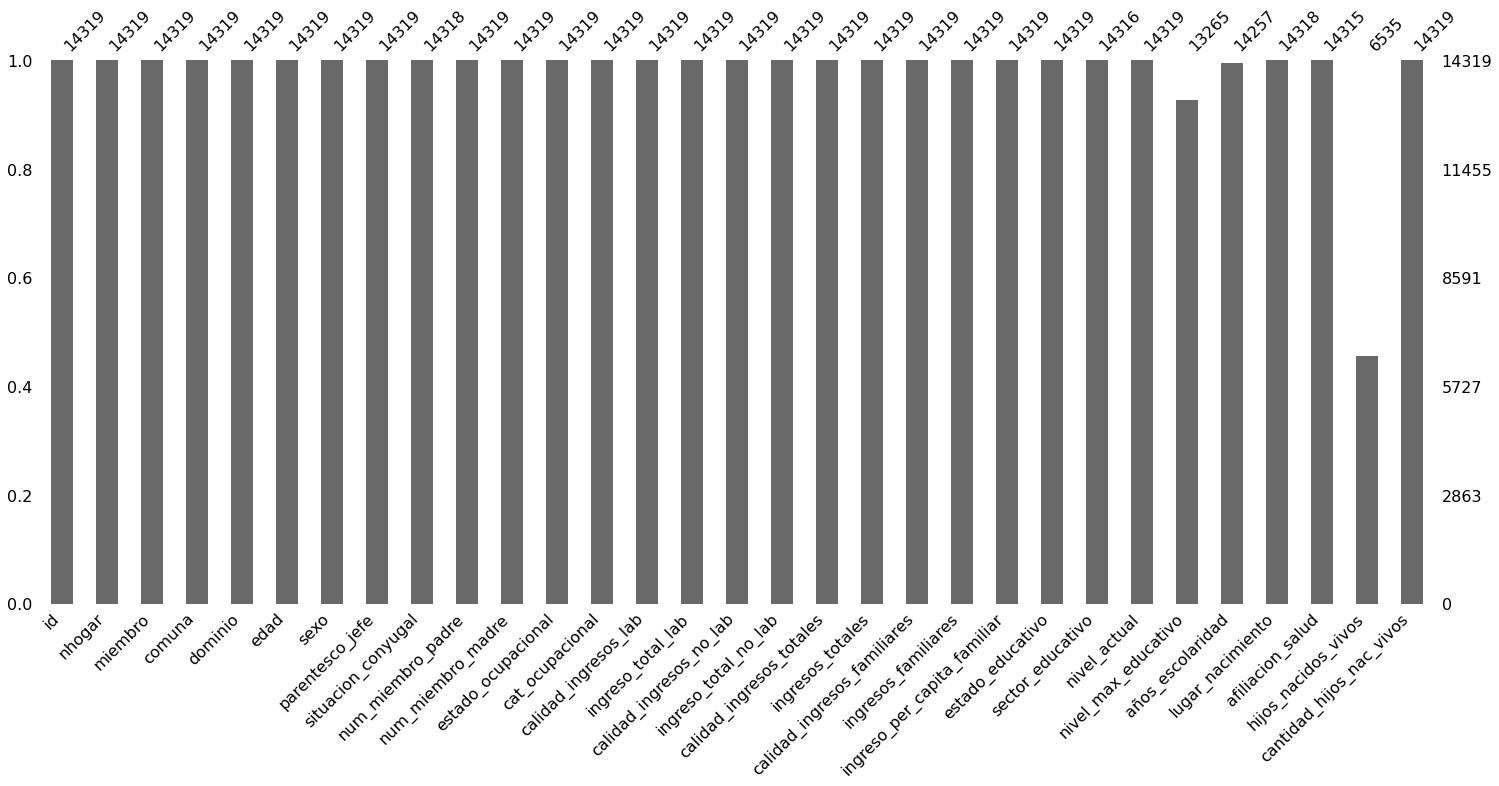

In [15]:
import missingno as msno
msno.bar(df);

# Género y Edad

Comenzamos con un pantayaso general sobre las primeras cualidades de los datos, 
como muestra representativa para la EPH, sobre quiénes son los ciudadanos representado en el dataset

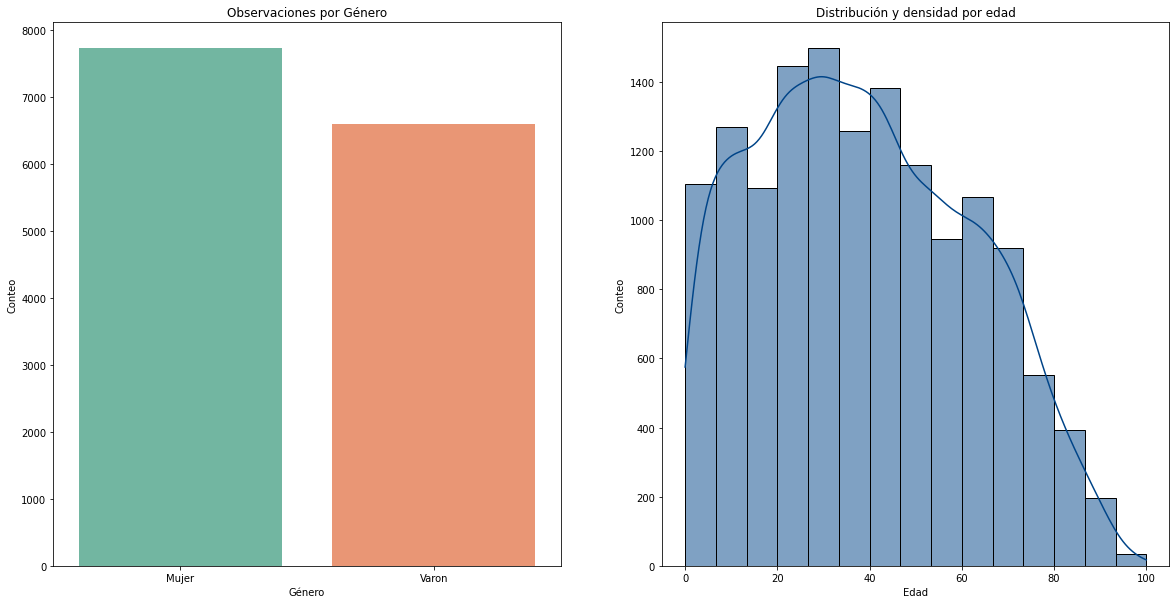

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sex = df['sexo']
edad = df['edad']


sns.countplot(x=sex, ax=axes[0], palette = 'Set2').set(title='Observaciones por Género', xlabel='Género', ylabel='Conteo');

sns.histplot(x=edad,
            ax=axes[1], 
            color='#004488',
            bins= 'sturges',
            kde=True).set(title='Distribución y densidad por edad', xlabel='Edad', ylabel='Conteo');


En la variable género los datos parecen equilibrados en las categorías. Para el caso de la variable "edad", la distribución se asemeja a la de una normal.

# Comuna

Seguimos observando la variable "comuna". En la misma se muestra la comuna de la Ciudad de Buenos Aires del entrevistado, de manera de tener una ubicación geográfica. Consideramos importante revisar esta variable ya que tenemos como hipótesis que el nivel educativo alcanzado puede estar dependiendo de la zona geográfica de la ciudad en la que se encuentra el entrevistado.

In [2]:
# Vamos a generar un mapa, así que vamos a importar el mapa de comunas de la Ciudad de Buenos Ainres
comunas = gpd.read_file("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/CABA_comunas.geojso")

# Transformamos la base para contablizar la frecuencia con la que aparece cada comuna en la base
com = pd.DataFrame(df["comuna"].value_counts()).reset_index()

#Transformamos las variables que vamos a usar para joinear el mapa con la base de manera que coincidan
comunas["COMUNAS"] = comunas["COMUNAS"].apply(float)

# Unimos ambos datasets
df_com = pd.merge(com,comunas[["COMUNAS","geometry"]],left_on="index",right_on="COMUNAS")

# Como el comando pd.merge devuelve un dataframe común, debemos transformarlo nuevamente en un dataset con componente geográfico
df_com = gpd.GeoDataFrame(df_com)

# Convertimos la variable COMUNAS en integer para que aparezca redondeada en el mapa
df_com["COMUNAS"] = df_com["COMUNAS"].apply(int)

#generamos el lienzo
fig , ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(20,8))
plt.rcParams.update({"font.size":9,"axes.titlesize":25,"axes.labelsize":15, 'font.family':'serif'})

#mapa
df_com[["comuna","geometry"]].plot(ax= ax[1],column="comuna",legend=True,cmap="viridis",
           legend_kwds={'label': ""})
#agrego un gráfico de barras
sns.barplot(data=df_com, x="COMUNAS", y='comuna', color='COMUNAS', palette='Paired', ax=ax[0])

#genero una nueva variable con las coordenadas para poder agregar etiquetas en el centro geográfico de cada comuna
df_com['coords'] = df_com['geometry'].apply(lambda x: x.representative_point().coords[:])
df_com['coords'] = [coords[0] for coords in df_com['coords']]

for idx, row in df_com.iterrows():
    plt.annotate(s=row['COMUNAS'], xy=row['coords'],
                 horizontalalignment='center',size=15,color="r")
    
#for i, v in enumerate(df_com["comuna"].iteritems()):        
#    ax[0].text(i ,v[1], "{:,}".format(v[1]), color='r', va ='top')

#Título y etiquetas de variables    
ax[0].set_title("Cantidad de encuestados por comuna")
ax[0].set_ylabel("Cantidad")
ax[0].set_xlabel("Comuna")
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False);


NameError: ignored

Observando los dos gráficos generados vemos que las comunas 1,4,7 y 8 tienen mayor cantidad de casos. Queda por verse si en posteriores análisis es necesario abordar esta diferencia para evitar sesgos. Para eso, será necesario tomar en cuenta el porcentaje de la población total de cada comuna.

#Ingreso familiar per capita

Ahora probamos con observar los ingresos familiares. Creemos que puede ser un indicador interesante del nivel educativo.



In [ ]:
#Armamos una función para graficar y jugar con el nivel del filtrado de la variable y obtener un histograma
#que permita apreciar mejor la distribución de la variable sin tantos outliers
def hist_box(DataFrame, #dataset
             x, #variable del gráfico
             limite,# frecuencia del rango para la etiqueta del eje x
             bins): 
  sns.set(style="white", rc={"lines.linewidth": 2, "font.size":9,"axes.titlesize":20,"axes.labelsize":17, 'font.family':'serif'})
  fig, ax = plt.subplots(figsize=(25,10),nrows=2,ncols=1,sharex=True)
  sns.histplot(x=x,
              data=df[df[x]<limite] ,
              color='#004488',
              ax=ax[1],
              bins= bins,
              kde=True)
  
  ax[0].boxplot(x=df[df[x]<limite][x],vert=False)
  ax[0].set_title(f"{x}",size=25)
  ax[1].set_title(f"{x} menor a {limite}",size=25)
  ax[0].set(xticks=range(0,limite+1,int(limite/20)))

In [ ]:
#probamos graficando con el máximo de la variable
hist_box(df,'ingreso_per_capita_familiar',max(df.ingreso_per_capita_familiar),bins=30);

Como hay muchos outliers que impiden ver la distribución correctamente, los quitamos de los gráficos.

In [ ]:
#Ahora probamos quitando los outliers
r75 = int(df.describe()["ingreso_per_capita_familiar"]["75%"]) #tercer cuartil
r25 = int(df.describe()["ingreso_per_capita_familiar"]["25%"]) #segundo cuartil

O = r75 + 1.5 * (r75-r25) #calculamos el límite inferior a los outliers
hist_box(df,"ingreso_per_capita_familiar",int(O),bins=30)

De este forma vemos que, aún removiendo los outliers, la distribución sigue sesgada.

#Años de escolaridad

Esta variable está muy relacionada al target, por lo que es interesante tenerla en cuenta para el análisis.

In [ ]:
df["años_escolaridad"].value_counts()

Al parecer python interpreta que la variable es object ya que en el dataset está la respuesta "Ningún año de escolaridad aprobado". Eso se puede remplazar con un cero para que se pueda pasar como numérico.

In [ ]:
#Remplazo los valores para que todos sean numéricos
df.loc[df.años_escolaridad=="Ningun año de escolaridad aprobado","años_escolaridad"]=0
df["años_escolaridad"] = df["años_escolaridad"].astype('float')

In [ ]:
df.describe()[["años_escolaridad"]].T


In [ ]:
fig, ax = plt.subplots(figsize=(10,7),sharex=True)

sns.histplot(x="años_escolaridad",
              data=df,
              color='#004488',
              ax=ax,
              bins= 10,
              kde=True);

A simple vista se observan tres "picos": en el valor mínimo, alrededor del 7.5 y alrededor del 12.5. Podemos inferir que estos tres casos corresponden a no tener estudios, solo haber transcurrido el primario y haber transcurrido hasta la educación secundaria, respectivamente.

#Máximo nivel educativo



In [ ]:
df.nivel_max_educativo.unique()

In [ ]:
df.stb.freq(['nivel_max_educativo'])

Podemos notar que pareciera que la concentración de datos en nivel educativo máximo se concentra en el nivel medio y superior. Sin embargo, al repetirse los niveles con otros nombres no queda claro

In [ ]:
#Creamos el target para nivel_max_educativo
def target(row):  
    if (row['nivel_max_educativo'] == 'Secundario/medio comun') | (row['nivel_max_educativo'] == 'EGB (1° a 9° año)'):
        return 'Secundario completo'
    elif (row['nivel_max_educativo'] == 'Primario especial') | (row['nivel_max_educativo'] == 'Primario comun'):
        return 'Primario completo'
    elif row['nivel_max_educativo'] == 'Sala de 5':
        return 'Nivel inicial'
    elif row['nivel_max_educativo'] == 'Otras escuelas especiales':
        return 'Nivel superior'

In [ ]:
df['Target'] = df.apply(lambda row: target(row), axis=1)


In [ ]:
df.info()

Ahora que tenemos la variable target como nos interesa, pasamos a observar su distribución

In [ ]:
df.stb.freq(['Target'])

In [ ]:
def freq_table(df, col):

  #seleccion de data
  data = df[col]

  #verificacion de columna y si queremos cortes de intervalos
  if not is_numeric_dtype(data) or not with_cuts:
    #generaion de tabla de frecuenca ,con info absoluta
    freq_tab = pd.crosstab(data, columns='FreqAbs').sort_values('FreqAbs', ascending=False)
   
  #calculo del resto de la tabla de frecuencia
  freq_tab['FreqRel'] = freq_tab['FreqAbs'] / freq_tab['FreqAbs'].sum()
  freq_tab[['FAbsAcumulada', 'FAbsRelativa']] = freq_tab[['FreqAbs','FreqRel']].cumsum()
  return freq_tab


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,13), sharey=True);


sns.histplot(x=df['Target'], ax=axes[0], color = 'C3').set(title='Observaciones por Nivel Máximo Educativo', xlabel='Nivel Educativo', ylabel='Frecuencia Absoluta');

nivel  = freq_table(df, 'Target').reset_index().sort_values('FreqAbs', ascending=False);

sns.barplot(data=nivel, x='Target', y='FreqAbs', ax=axes[1], color="C0").set(title='Gráfico de Pareto para  Nivel Máximo Educativo', xlabel='Nivel Educativo', ylabel='Frecuencia Absoluta');
ax2 = axes[1].twinx();
sns.lineplot(nivel['Target'], nivel["FAbsRelativa"], color="C1", marker="o", ms=5, ax=ax2);
axes[0].tick_params(axis='x', rotation=70);
axes[1].tick_params(axis='x', rotation=70);

# plt.show()
# sns.set()



**Podemos observar que el nivel maximo educativo más alcanzado es el secundario completo, seguido por el primario. Contrario de lo que habíamos intuido anteriormente, el nivel superior quedó en tercer lugar. 
Adicionalmente, el nivel secundario y primario explican casi el 77% de los datos.**